In [80]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
import numpy as np
import matplotlib.pyplot as plt
import os

from array_utils import load_npz, write_npz
from mnist.ensemble import generate_ensemble_stats
from mnist.bald import bald_confidence
from metrics_lib import compute_accuracies_at_confidences, compute_confidences

In [82]:
thresholds = np.linspace(0, 1, 50, endpoint=False)

In [83]:
# calculate data for ensemble
stats = generate_ensemble_stats('mnist/results/ensemble', 'stats_small_0.npz', 15)
write_npz('mnist/results/ensemble/', 'stats_small_28.npz', stats)

1.0000002667220542
2.000000147441824
3.000000195141183
3.99999982592999
4.999999729101546
6.000000201354851
7.00000022893073
8.000000085492502
8.999999892199412
9.999999459279934
10.999999551037035
12.000000019841536
12.999999919462425
14.0000001477747
15.000000670872396
Recording stats to mnist/results/ensemble//stats_small_28.npz


In [96]:
# generate confidence bins for all methods
ood_name = 'stats_small_28.npz'
methods = ['vanilla', 'svi', 'dropout', 'll_svi', 'll_dropout', 'ensemble']
bald_methods = ['dropout', 'll_dropout']

counts = {}

for method in methods:
    path = os.path.join('mnist/results/',method, ood_name)
    stats = load_npz(path)
    _, counts[method] = compute_accuracies_at_confidences(stats['labels'], stats['probs'], thresholds)
    
for method in bald_methods:
    path = os.path.join('mnist/results/',method, 'stats_28.npz')
    stats = load_npz(path)
    confidence = compute_confidences(bald_confidence(stats), thresholds)
    counts[method+'_bald'] = confidence



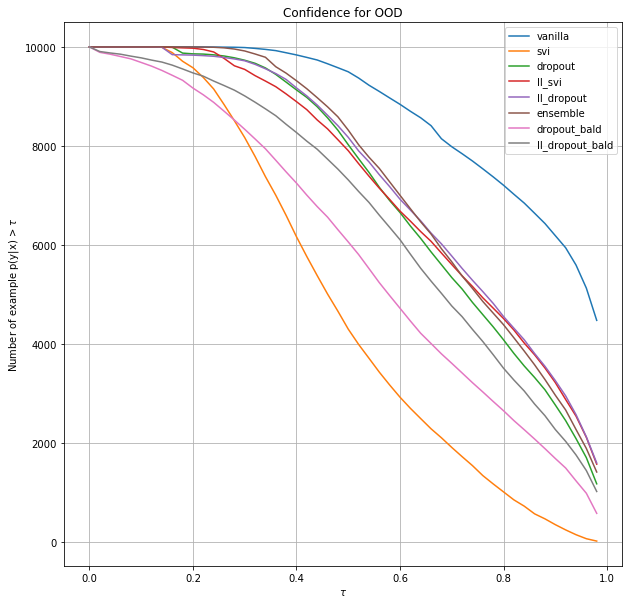

In [95]:
# plot results
plt.figure(figsize=(10, 10))
for method, count in counts.items():
    plt.plot(thresholds, count, label=method)
plt.title('Confidence for OOD')
plt.xlabel(r'$\tau$')
plt.ylabel(r'Number of example p(y|x) > $\tau$')
plt.grid(True)
plt.legend()
plt.show()

In [94]:
# Show counts, when close to confidence 1
for method, count in counts.items():
    print(method, '\n', count[-5:])

vanilla 
 [6191. 5946. 5598. 5131. 4481.]
svi 
 [358. 252. 155.  74.  26.]
dropout 
 [2773. 2457. 2095. 1709. 1182.]
ll_svi 
 [3226. 2884. 2549. 2119. 1579.]
ll_dropout 
 [3266. 2957. 2579. 2130. 1603.]
ensemble 
 [2971. 2672. 2279. 1895. 1420.]
dropout_bald 
 [1693. 1501. 1242.  991.  586.]
ll_dropout_bald 
 [2278. 2039. 1765. 1449. 1027.]
